In [ ]:
!pip install transformers
!pip install pytorch-lightning

# Import lib

In [23]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import LayerNorm
from torch.nn import functional as F
from transformers import AutoModel, AutoTokenizer, AdamW, get_cosine_schedule_with_warmup
import json
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import re
import nltk
from nltk.tokenize import word_tokenize
import math
from google.colab import drive
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Import dataset

In [13]:
from google.colab import files
uploaded = files.upload()

Saving vietnamese-stopwords.txt to vietnamese-stopwords.txt


In [3]:
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


In [4]:
# Load data from CSV file
df = pd.read_csv('/content/drive/MyDrive/data/raw_data.csv', encoding='utf-8-sig')

# Visualize Data

In [5]:
df.head()

,Content,Label
0,"Vingroup báo lãi hơn 3.600 tỷ đồng, doanh thu ...",VIC
1,HAGL Agrico (HNG) lỗ quý thứ 5 liên tiếp. Giá ...,HNG
2,"Vingroup lãi ròng 1.028 tỷ đồng nửa đầu năm, t...",VIC
3,Một doanh nghiệp khoáng sản đã vượt 153% mục t...,KSV
4,Doanh nghiệp thép từ lớn đến nhỏ đều báo lỗ qu...,HPG


In [6]:
# Count the number of words in each article's content and number of times a class appear
df['Word Count'] = df['Content'].apply(lambda x: len(str(x).split()))
df['Class Count'] = df.groupby('Label')['Label'].transform('count')

# Calculate statistics for word count
df['Word Count'].describe()

count    10396.000000
mean       607.325414
std        352.123889
min         46.000000
25%        381.000000
50%        514.000000
75%        725.250000
max       4235.000000
Name: Word Count, dtype: float64

In [7]:
df.head()

,Content,Label,Word Count,Class Count
0,"Vingroup báo lãi hơn 3.600 tỷ đồng, doanh thu ...",VIC,599,108
1,HAGL Agrico (HNG) lỗ quý thứ 5 liên tiếp. Giá ...,HNG,642,65
2,"Vingroup lãi ròng 1.028 tỷ đồng nửa đầu năm, t...",VIC,577,108
3,Một doanh nghiệp khoáng sản đã vượt 153% mục t...,KSV,430,3
4,Doanh nghiệp thép từ lớn đến nhỏ đều báo lỗ qu...,HPG,1247,197


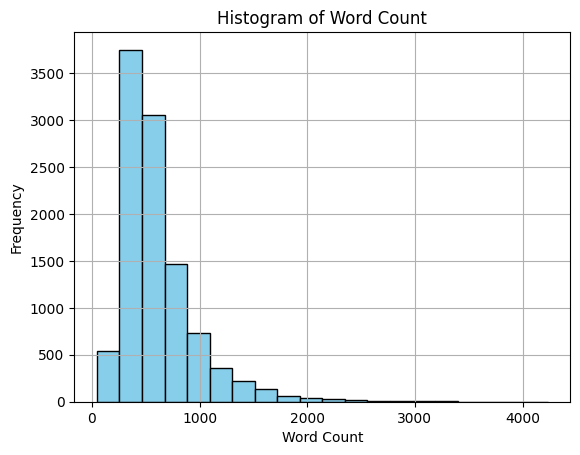

In [8]:
# Plot histogram for word count
plt.hist(df['Word Count'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
# Count the occurrence of each unique label
label_counts = df['Label'].value_counts()
print(label_counts.describe())

# Loop over each unique label and print its count
for label, count in label_counts.items():
    print(f"Label: {label}, Count: {count}")

In [10]:
# extracted_df
e_df = df.loc[df['Class Count'] > 5].sort_values(by="Class Count", ascending=False)
e_df.count()

Content        9222
Label          9222
Word Count     9222
Class Count    9222
dtype: int64

In [11]:
number_of_classes = e_df['Label'].nunique()
number_of_classes

350

# Processing Dataset

## Clean text

In [14]:
with open('vietnamese-stopwords.txt', 'r', encoding='utf-8') as f:
    vietnamese_stopwords = f.read().splitlines()

vietnamese_stopwords[:10]

['a lô',
 'a ha',
 'ai',
 'ai ai',
 'ai nấy',
 'ai đó',
 'alô',
 'amen',
 'anh',
 'anh ấy']

In [15]:
def clean_text(txt):
    txt = re.sub('\s+', ' ', txt)
    txt = txt.replace('.','')
    txt = re.sub('\n', ' ', txt)
    txt = [word_tokenize(wrd) for wrd in txt.split() if wrd not in vietnamese_stopwords]
    txt = [item[0] for item in txt]
    txt = ' '.join(txt)
    return txt

clean_text(" VinFast chính thức vận hành 35 showroom xe máy điện kết hợp trung tâm trải nghiệm Vin3S tại 24 tỉnh, thành phố trên cả nước")

'VinFast thức vận hành 35 showroom xe máy điện kết hợp trung tâm trải nghiệm Vin3S 24 tỉnh thành phố'

## Split trainset valset

In [53]:
trainset, valset = train_test_split(e_df, test_size=0.2, random_state=42)

## ArticleDataset Class

In [90]:
class ArticleDataset(Dataset):
    def __init__(self, data, labels, tokenizer, max_length=512):
        self.data = data
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text=item.Content,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


## Transform labels

In [ ]:
print(os.getcwd())

/content


In [91]:
labels_list = e_df['Label'].tolist()
print(labels_list[:10])

['HPG', 'HPG', 'HPG', 'HPG', 'HPG', 'HPG', 'HPG', 'HPG', 'HPG', 'HPG']


In [92]:
le = LabelEncoder()
labels = le.fit_transform(labels_list).tolist()
print(labels)

[122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 176, 176, 176,

# Load phoBERT tokenizer

In [93]:
# Load pre-trained tokenizer
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [67]:
text = "công tyNếu tính GJK"
print(tokenizer.encode(text))
text = "công ty Nếu tính gjk"
print(tokenizer.encode(text))

[0, 675, 6745, 313, 294, 1276, 2136, 2260, 2]
[0, 675, 6892, 313, 294, 1529, 57202, 2]


# Hyperparameters


In [94]:
MAX_LENGTH = 512  # Adjust as needed
BATCH_SIZE = 32
N_CLASSES = number_of_classes  # Replace with your actual number of classes
EPOCHS = 30

## Pytorch Lightning DataModule

In [100]:
class Data_Module(pl.LightningDataModule):

  def __init__(self, trainset, valset, labels, batch_size: int = 32, max_token_length: int = 512, tokenizer=None):
    super().__init__()
    self.trainset = trainset
    self.val_path = valset
    self.labels = labels
    self.batch_size = batch_size
    self.max_token_length = max_token_length
    self.tokenizer = tokenizer

  def setup(self, stage = None):
    if stage in (None, "fit"):
      self.train_dataset = ArticleDataset(self.trainset, self.labels, self.tokenizer, self.max_token_length)
      self.val_dataset = ArticleDataset(self.val_path, self.labels, self.tokenizer, self.max_token_length)
    if stage == 'predict':
      self.val_dataset = ArticleDataset(self.val_path, self.labels, self.tokenizer, self.max_token_length)

  def train_dataloader(self):
    return DataLoader(self.train_dataset, batch_size = self.batch_size, num_workers=2, shuffle=True)

  def val_dataloader(self):
    return DataLoader(self.val_dataset, batch_size = self.batch_size, num_workers=2, shuffle=False)

  def predict_dataloader(self):
    return DataLoader(self.val_dataset, batch_size = self.batch_size, num_workers=2, shuffle=False)

## Create PyTorch lightning DataLoader

In [101]:
# Create PyTorch lightning DataLoader
data_loader = Data_Module(trainset, valset, labels, BATCH_SIZE, MAX_LENGTH, tokenizer)
data_loader.setup()

# Model architecture

In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [124]:
class ArticleClassifier(pl.LightningModule):
    def __init__(self, config: dict):
        super().__init__()
        self.config = config
        self.bert = AutoModel.from_pretrained(config['model_name'], return_dict = True)
        self.batch_norm = nn.BatchNorm1d(self.bert.config.hidden_size)
        self.fc1 = nn.Linear(self.bert.config.hidden_size, 128)  # Adjusted the input size to match the bert's hidden size
        self.dropout1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(128, 256)
        self.dropout2 = nn.Dropout(0.4)
        self.layer_norm = LayerNorm(256)
        self.output = nn.Linear(256, self.config['n_labels'])
        self.loss = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask, labels=None):
        x = self.bert(input_ids, attention_mask=attention_mask)[0]
        x = torch.mean(x, 1)
        x = self.batch_norm(x)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.layer_norm(x)
        x = self.output(x)  # Remove softmax activation here
        return x

    def training_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        outputs = self(input_ids, attention_mask)
        loss = self.loss(outputs, labels)
        self.log('train_loss', loss, prog_bar=True, logger=True)
        return {"loss": loss, "predictions": outputs, "labels": labels}


    def validation_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        outputs = self(input_ids, attention_mask)
        loss = self.loss(outputs, labels)
        self.log('val_loss', loss, prog_bar=True, logger=True)
        return {"val_loss": loss, "predictions": outputs, "labels": labels}

    def predict_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        outputs = self(input_ids, attention_mask)
        return outputs

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=self.config['lr'], weight_decay=self.config['weight_decay'])
        total_steps = self.config['train_size']/self.config['batch_size']
        warmup_steps = math.floor(total_steps * self.config['warmup'])
        warmup_steps = math.floor(total_steps * self.config['warmup'])
        scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
        return [optimizer],[scheduler]

# Initialize Model

## Model configuration

In [120]:
config = {
    'model_name': 'vinai/phobert-base',
    'n_labels': number_of_classes,
    'batch_size': 128,
    'lr': 1.5e-6,
    'warmup': 0.2,
    'train_size': len(data_loader.train_dataloader()),
    'weight_decay': 0.001,
    'n_epochs': 100
}

## Create model

In [125]:
# Initialize our classifier
model = ArticleClassifier(config)
model = model.to(device)

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



# Train Model

In [126]:
trainer = pl.Trainer(max_epochs=config['n_epochs'], num_sanity_val_steps=50)
trainer.fit(model, data_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params
------------------------------------------------
0 | bert       | RobertaModel     | 134 M 
1 | batch_norm | BatchNorm1d      | 1.5 K 
2 | fc1        | Linear           | 98.4 K
3 | dropout1   

Sanity Checking: 0it [00:00, ?it/s]

RuntimeError: ignored